In [1]:
import numpy as np
import xarray as xr
import dask
import scipy.stats as stats
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
spkws = dict(projection = ccrs.PlateCarree(), transform = ccrs.PlateCarree())

from siphon.catalog import TDSCatalog
from xclim.core.calendar import convert_calendar, percentile_doy
import xclim.indicators as xci

# pysal.esda for spatial autocorrelation analysis
import esda 
import libpysal as lps

# URL for PAVICS' THREDDS server which hosts gridded observations and downscaled data
url_pavics = "https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/catalog/datasets/"
url_obs = url_pavics + "gridded_obs/catalog.xml"
url_downscaled = url_pavics + "simulations/bias_adjusted/cmip6/pcic/CanDCS-U6/catalog.xml"

# centre of domain to analyze
lat_mtl = 45.5019
lon_mtl = -73.5674

# bounds of domain
lons = [lon_mtl - 1, lon_mtl + 1]
lats = [lat_mtl - 0.25, lat_mtl + 0.75]


In [2]:
# Create Catalog object - this contains the info for the datasets in this directory
cat_obs = TDSCatalog(url_obs)

# open the obs dataset and load the tasmax data
cds_obs = cat_obs.datasets[0] 
obs_ds = xr.open_dataset(cds_obs.access_urls["OPENDAP"])

# select and spatial domain
obs_ds = obs_ds.sel(lat = slice(*lats[::-1]), lon = slice(*lons))

# reverse latitude dimension to match model - with latitudes increasing with the index
obs_ds = obs_ds.isel(lat=slice(None, None, -1))

# select variable and time period, and convert units
variable_name = 'tasmin'
data_obs = obs_ds[variable_name] - 273.15
data_obs_train = data_obs.sel(time = obs_ds.time.dt.year.isin(range(1950, 2006))).load() 
data_obs_test = data_obs.sel(time = obs_ds.time.dt.year.isin(range(2006, 2018))).load() 


In [3]:
# same procedure for accessing model data
cat_sds = TDSCatalog(url_downscaled)

# open the gcm dataset and load the tasmax data
opendap_urls = [cat_sds.datasets[i].access_urls["OPENDAP"] for i in range(len(cat_sds.datasets))]
datasets_canesm = list(filter(lambda x: 'CanESM' in x, opendap_urls))

url_gcm = datasets_canesm[0] 
print(url_gcm)
gcm_ds = xr.open_dataset(url_gcm)
gcm_ds = gcm_ds.sel(lat = slice(*lats), lon = slice(*lons))

data_gcm = gcm_ds.tasmin
data_gcm_train = gcm_ds[variable_name].sel(time = gcm_ds.time.dt.year.isin(range(1950, 2006))).load() 
data_gcm_test = gcm_ds[variable_name].sel(time = gcm_ds.time.dt.year.isin(range(2006, 2018))).load() 

https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/dodsC/datasets/simulations/bias_adjusted/cmip6/pcic/CanDCS-U6/day_BCCAQv2+ANUSPLIN300_CanESM5_historical+ssp585_r9i1p2f1_gn_1950-2100.ncml


In [4]:
# convert obs calendar to match model
data_obs_train = convert_calendar(data_obs_train, 'noleap')
data_obs_test = convert_calendar(data_obs_test, 'noleap')

/Users/mikemorris/opt/anaconda3/envs/UTCDW-env2/lib/python3.12/site-packages/xclim/core/calendar.py:92: FutureWarning: `xclim` function convert_calendar is deprecated in favour of xarray.coding.calendar_ops.convert_calendar or obj.convert_calendar and will be removed in v0.51.0. Please adjust your script.
  warn(
/Users/mikemorris/opt/anaconda3/envs/UTCDW-env2/lib/python3.12/site-packages/xclim/core/calendar.py:92: FutureWarning: `xclim` function convert_calendar is deprecated in favour of xarray.coding.calendar_ops.convert_calendar or obj.convert_calendar and will be removed in v0.51.0. Please adjust your script.
  warn(


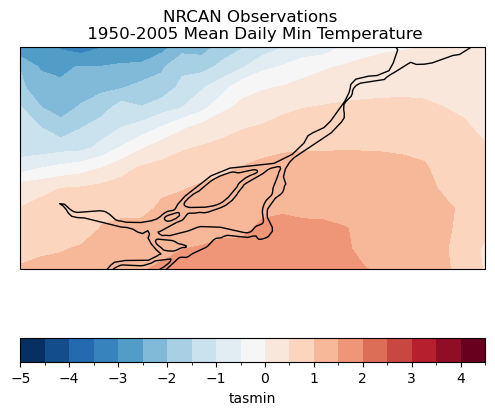

In [5]:
# plot the training sample long term means, just to compare quickly
data_mean_obs_train = data_obs_train.mean('time') 

fig, ax = plt.subplots(subplot_kw = spkws, figsize = (6,6))
data_mean_obs_train.plot.contourf(ax = ax, levels = np.arange(-5, 5, 0.5),
                                 cbar_kwargs = dict(orientation='horizontal', 
                                                    extendrect = True),
                                 zorder = 0)
ax.add_feature(cfeature.LAKES, edgecolor = 'k', facecolor = 'none', zorder = 2)
ax.coastlines()
ax.set_title("NRCAN Observations \n 1950-2005 Mean Daily Min Temperature")
plt.show()

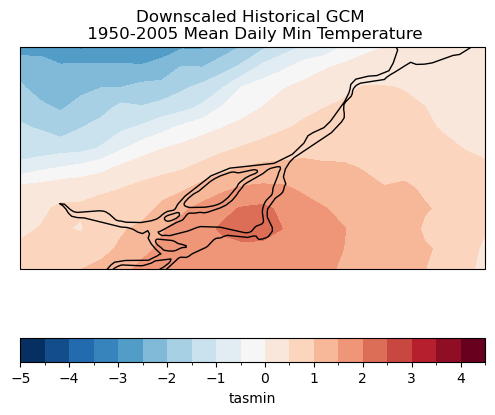

In [6]:
data_mean_gcm_train = data_gcm_train.mean('time') 

fig, ax = plt.subplots(subplot_kw = spkws, figsize = (6,6))
data_mean_gcm_train.plot.contourf(ax = ax, levels = np.arange(-5, 5, 0.5),
                                 cbar_kwargs = dict(orientation='horizontal', 
                                                    extendrect = True),
                                 zorder = 0)
ax.add_feature(cfeature.LAKES, edgecolor = 'k', facecolor = 'none', zorder = 2)
ax.coastlines()
ax.set_title("Downscaled Historical GCM \n 1950-2005 Mean Daily Min Temperature")
plt.show()

In [7]:
# define a function that returns only the p-value, not the test statistic
get_ks_pval = lambda x,y: stats.ks_2samp(x, y).pvalue

# perform the test at each grid cell
ks_pvals_train = xr.apply_ufunc(get_ks_pval, 
# coordinate values are slightly mismatched, interp gcm to obs grid
                                data_gcm_train.interp(lat = data_obs_train.lat, 
                                                      lon = data_obs_train.lon),
                                data_obs_train,
                                input_core_dims = [['time'], ['time']], 
                                vectorize = True)

ks_pvals_test = xr.apply_ufunc(get_ks_pval, 
                               data_gcm_test.interp(lat = data_obs_test.lat, 
                                                    lon = data_obs_test.lon), 
                               data_obs_test,
                               input_core_dims = [['time'], ['time']], 
                               vectorize = True)

# mask where data is missing (if any)
ks_pvals_train = ks_pvals_train.where(~np.isnan(data_obs_train.isel(time=0)))
ks_pvals_test = ks_pvals_test.where(~np.isnan(data_obs_test.isel(time=0)))

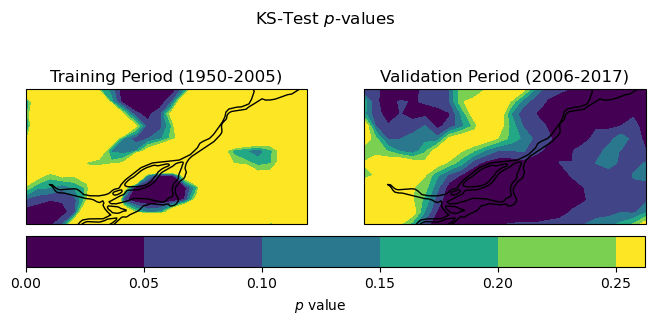

In [8]:
# plot
fig, axes = plt.subplots(ncols = 2, subplot_kw = spkws, figsize = (8,3))
fig.suptitle(r"KS-Test $p$-values")

p1 = ks_pvals_train.plot.contourf(ax = axes[0], levels = np.arange(0, 0.3, 0.05), add_colorbar = False)
axes[0].set_title("Training Period (1950-2005)")

p2 = ks_pvals_test.plot.contourf(ax = axes[1], levels = np.arange(0, 0.3, 0.05), add_colorbar = False)
axes[1].set_title("Validation Period (2006-2017)")

fig.colorbar(p1, ax = axes.ravel().tolist(), label = r"$p$ value", 
             orientation='horizontal', extendrect = True,
             pad = 0.05)
for ax in axes:
    ax.add_feature(cfeature.LAKES, edgecolor = 'k', facecolor = 'none', zorder = 2)
    ax.coastlines()

plt.show()

In [9]:
# construct a list of (lon, lat) tuples to use to construct the spatial weights
nlat = len(data_obs_train.lat)
nlon = len(data_obs_train.lon)
npts =  nlat * nlon

pts = []

for i in range(nlat):
    for j in range(nlon):
        pts += [(data_obs_train.lon[j], data_obs_train.lat[i])]
        


In [10]:
# construct the kNN weights (k=8)
k = 8
weights = lps.weights.KNN.from_array(pts, k)

In [11]:
# lambda function to use with xr.apply_ufunc, so we don't need to pass extra args
moran_I = lambda x: esda.Moran(x, weights).I

# calculate Moran's I for each timestep for the validation period.
moran_obs_test = xr.apply_ufunc(moran_I, data_obs_test,
                                input_core_dims = [['lat','lon']], 
                                output_dtypes = [float],
                                vectorize = True)

In [12]:
moran_gcm_test = xr.apply_ufunc(moran_I, data_gcm_test,
                                input_core_dims = [['lat','lon']], 
                                output_dtypes = [float],
                                vectorize = True)

In [13]:
# calculate mean and stdev's over time
moran_obs_test_mean = moran_obs_test.mean('time')
moran_gcm_test_mean = moran_gcm_test.mean('time')
moran_obs_test_std = moran_obs_test.std('time')
moran_gcm_test_std = moran_gcm_test.std('time')


print("Obs Moran I: %.2f" % moran_obs_test_mean.values, 
      "+/- %.2f" % moran_obs_test_std.values)
print("Downscaled GCM Moran I: %.2f" % moran_gcm_test_mean.values,
      "+/- %.2f" % moran_gcm_test_std.values)

Obs Moran I: 0.95 +/- 0.02
Downscaled GCM Moran I: 0.92 +/- 0.04


In [14]:
# subtract daily climatology to get daily anomalies
data_obs_test_mean = data_obs_test.groupby('time.dayofyear').mean('time')
data_obs_test_demeaned = data_obs_test.groupby('time.dayofyear') - data_obs_test_mean

# calculate variance and number of samples
var_obs_test = data_obs_test_demeaned.var('time')
ntime_obs_test = len(data_obs_test.time)



In [15]:
autocov = lambda x: np.correlate(x,x,mode='same')
# calculate the numerator of the r_k expression
autocov_obs_test = xr.apply_ufunc(autocov, data_obs_test_demeaned,
                                  input_core_dims = [['time']],
                                  output_core_dims = [['time']],
                                  output_dtypes = [float],
                                  vectorize = True,
                                  dask = 'allowed')

# re-name the 'time' dimension to 'lag' 
# to reflect what the results represent, and assign lag values
autocov_obs_test = autocov_obs_test.rename({'time': 'lag'})
autocov_obs_test['lag'] = np.arange(-ntime_obs_test//2, ntime_obs_test//2, 1)

# now compute the autocorrelation from the autocovariance
autocor_obs_test = autocov_obs_test / (ntime_obs_test * var_obs_test)

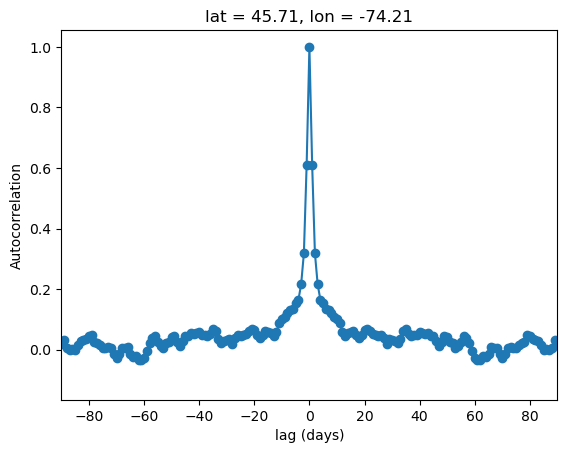

In [16]:
fig, ax = plt.subplots()
autocor_obs_test.isel(lat = 5, lon = 4).plot(ax = ax, marker = 'o')
ax.set_xlim(-90, 90)
ax.set_ylabel("Autocorrelation")
ax.set_xlabel("lag (days)")
plt.show()

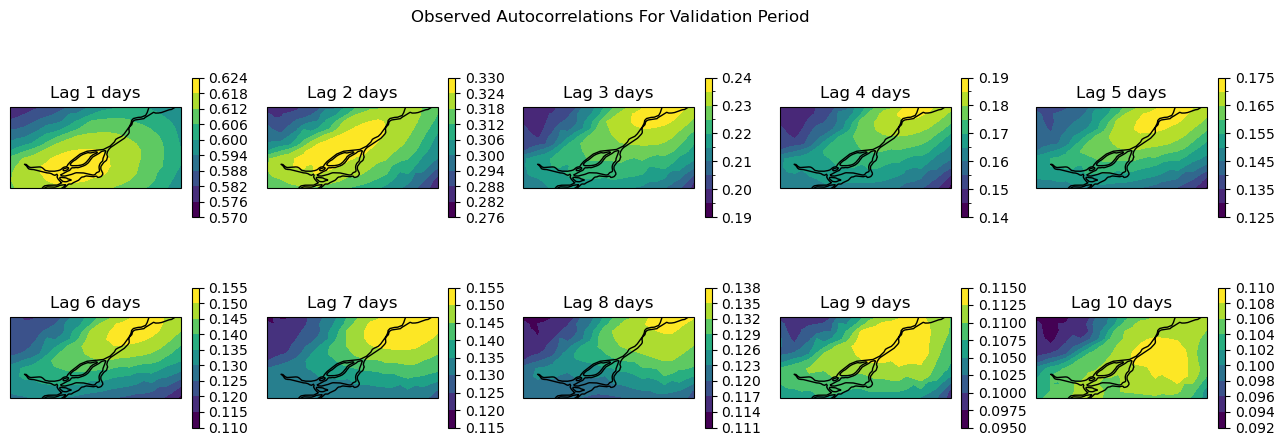

In [17]:
fig, axes_array = plt.subplots(nrows = 2, 
                               ncols = 5, 
                               subplot_kw = spkws, 
                               figsize = (16, 5))
fig.suptitle("Observed Autocorrelations For Validation Period")
axes = axes_array.ravel()
for i in range(len(axes)):
    p = autocor_obs_test.sel(lag = i + 1).plot.contourf(ax = axes[i],
                                                        levels = 10, 
                                                        cbar_kwargs = {'label': None, 
                                                                       'shrink': 0.8})
                                                        
    axes[i].coastlines()
    axes[i].add_feature(cfeature.LAKES, edgecolor = 'k', 
                        facecolor = 'none', zorder = 2)
    axes[i].set_title(f"Lag {i+1} days")

plt.show()

In [18]:
# do the same steps as for the obs autocorrelation, but for the downscaled GCM data
data_gcm_test_mean = data_gcm_test.groupby('time.dayofyear').mean('time')
data_gcm_test_demeaned = data_gcm_test.groupby('time.dayofyear') - data_gcm_test_mean

var_gcm_test = data_gcm_test_demeaned.var('time')
ntime_gcm_test = len(data_gcm_test.time)


autocov_gcm_test = xr.apply_ufunc(autocov, data_gcm_test_demeaned,
                                  input_core_dims = [['time']],
                                  output_core_dims = [['time']],
                                  output_dtypes = [float],
                                  vectorize = True,
                                  dask = 'allowed')

autocov_gcm_test = autocov_gcm_test.rename({'time': 'lag'})
autocov_gcm_test['lag'] = np.arange(-ntime_gcm_test//2, ntime_gcm_test//2, 1)

autocor_gcm_test = autocov_gcm_test / (ntime_gcm_test * var_gcm_test)

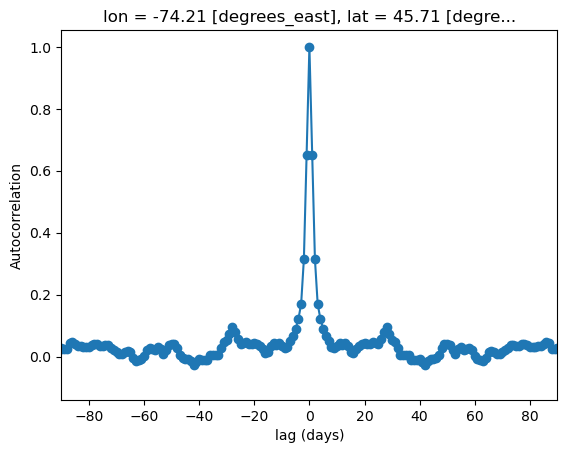

In [19]:
fig, ax = plt.subplots()
autocor_gcm_test.isel(lat = 5, lon = 4).plot(ax = ax, marker = 'o')
ax.set_xlim(-90, 90)
ax.set_ylabel("Autocorrelation")
ax.set_xlabel("lag (days)")
plt.show()

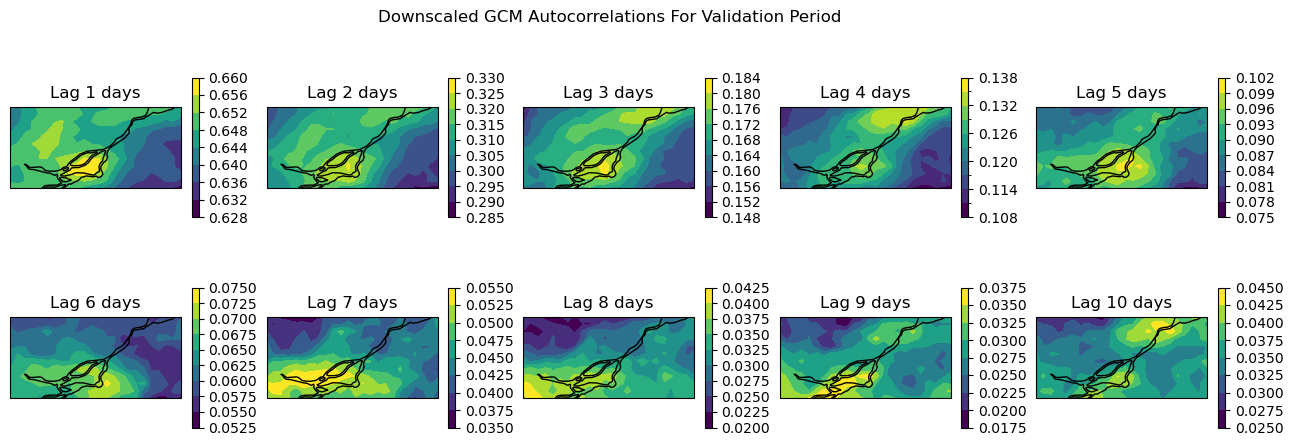

In [20]:
fig, axes_array = plt.subplots(nrows = 2, 
                               ncols = 5, 
                               subplot_kw = spkws, figsize = (16, 5))
fig.suptitle("Downscaled GCM Autocorrelations For Validation Period")
axes = axes_array.ravel()
for i in range(len(axes)):
    p = autocor_gcm_test.sel(lag = i + 1).plot.contourf(ax = axes[i],
                                                        levels = 10, 
                                                        cbar_kwargs = {'label': None, 
                                                                       'shrink': 0.8})
                                                        
    axes[i].coastlines()
    axes[i].add_feature(cfeature.LAKES, edgecolor = 'k', 
                        facecolor = 'none', zorder = 2)
    axes[i].set_title(f"Lag {i+1} days")

plt.show()

In [21]:
# assign units to all data, for use with xclim
data_obs_train.attrs['units'] = 'degC'
data_obs_test.attrs['units'] = 'degC'

data_gcm_train.attrs['units'] = 'degC'
data_gcm_test.attrs['units'] = 'degC'

# calculate Tropical Nights
tn_obs_train = xci.atmos.tropical_nights(data_obs_train)
tn_obs_test = xci.atmos.tropical_nights(data_obs_test)

tn_gcm_train = xci.atmos.tropical_nights(data_gcm_train)
tn_gcm_test = xci.atmos.tropical_nights(data_gcm_test)

/Users/mikemorris/opt/anaconda3/envs/UTCDW-env2/lib/python3.12/site-packages/xclim/core/cfchecks.py:42: UserWarning: Variable does not have a `cell_methods` attribute.
  _check_cell_methods(
/Users/mikemorris/opt/anaconda3/envs/UTCDW-env2/lib/python3.12/site-packages/xclim/core/cfchecks.py:46: UserWarning: Variable does not have a `standard_name` attribute.
  check_valid(vardata, "standard_name", data["standard_name"])


/Users/mikemorris/opt/anaconda3/envs/UTCDW-env2/lib/python3.12/site-packages/xclim/core/cfchecks.py:42: UserWarning: Variable does not have a `cell_methods` attribute.
  _check_cell_methods(
/Users/mikemorris/opt/anaconda3/envs/UTCDW-env2/lib/python3.12/site-packages/xclim/core/cfchecks.py:46: UserWarning: Variable does not have a `standard_name` attribute.
  check_valid(vardata, "standard_name", data["standard_name"])


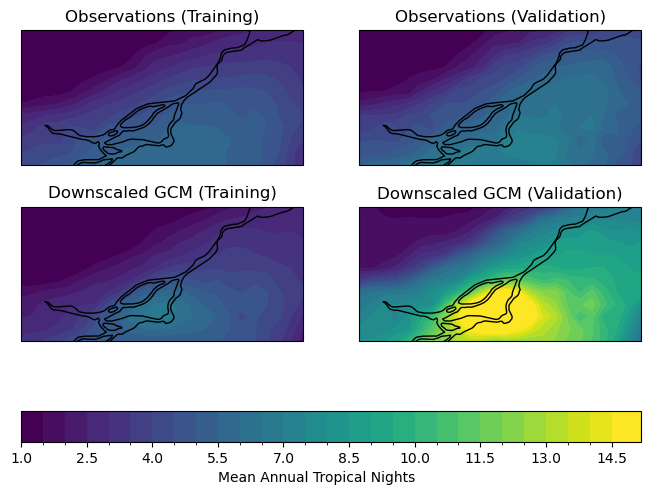

In [22]:
# plot maps of average annual Tropical Nights
clevs_tn = np.arange(1, 15, 0.5)
fig, axes_array = plt.subplots(nrows = 2, ncols = 2, 
                               figsize = (8,6), subplot_kw = spkws)
axes = axes_array.ravel()

tn_obs_train.mean('time').plot.contourf(ax = axes[0], levels = clevs_tn, 
                                        add_colorbar = False)
axes[0].set_title("Observations (Training)")

tn_obs_test.mean('time').plot.contourf(ax = axes[1], levels = clevs_tn, 
                                       add_colorbar = False)
axes[1].set_title("Observations (Validation)")

tn_gcm_train.mean('time').plot.contourf(ax = axes[2], levels = clevs_tn, 
                                        add_colorbar = False)
axes[2].set_title("Downscaled GCM (Training)")

p = tn_gcm_test.mean('time').plot.contourf(ax = axes[3], levels = clevs_tn, 
                                           add_colorbar = False)
axes[3].set_title("Downscaled GCM (Validation)")

fig.colorbar(p, ax = axes.tolist(), 
             extendrect = True,
             orientation = 'horizontal', 
             label = "Mean Annual Tropical Nights")

for ax in axes:
    ax.coastlines()
plt.show()

In [23]:
# select obs and downscaled GCM data for the reference period
ref_yrs = range(1961, 1991) # remember Python ranges are not inclusive of the endpoint
data_obs_ref = data_obs_train.sel(time = data_obs_train.time.dt.year.isin(ref_yrs))
data_gcm_ref = data_gcm_train.sel(time = data_gcm_train.time.dt.year.isin(ref_yrs))

# calculate 10th percentile threshold
data_obs_10p = percentile_doy(data_obs_ref, per = 10).sel(percentiles = 10)
data_gcm_10p = percentile_doy(data_gcm_ref, per = 10).sel(percentiles = 10)

# calculate CSDI for train and test, obs and GCM
CSDI_obs_train = xci.atmos.cold_spell_duration_index(data_obs_train, data_obs_10p)
CSDI_obs_test = xci.atmos.cold_spell_duration_index(data_obs_test, data_obs_10p)

CSDI_gcm_train = xci.atmos.cold_spell_duration_index(data_gcm_train, data_gcm_10p)
CSDI_gcm_test = xci.atmos.cold_spell_duration_index(data_gcm_test, data_gcm_10p)

/Users/mikemorris/opt/anaconda3/envs/UTCDW-env2/lib/python3.12/site-packages/xclim/core/cfchecks.py:42: UserWarning: Variable does not have a `cell_methods` attribute.
  _check_cell_methods(
/Users/mikemorris/opt/anaconda3/envs/UTCDW-env2/lib/python3.12/site-packages/xclim/core/cfchecks.py:46: UserWarning: Variable does not have a `standard_name` attribute.
  check_valid(vardata, "standard_name", data["standard_name"])


/Users/mikemorris/opt/anaconda3/envs/UTCDW-env2/lib/python3.12/site-packages/xclim/core/cfchecks.py:42: UserWarning: Variable does not have a `cell_methods` attribute.
  _check_cell_methods(
/Users/mikemorris/opt/anaconda3/envs/UTCDW-env2/lib/python3.12/site-packages/xclim/core/cfchecks.py:46: UserWarning: Variable does not have a `standard_name` attribute.
  check_valid(vardata, "standard_name", data["standard_name"])


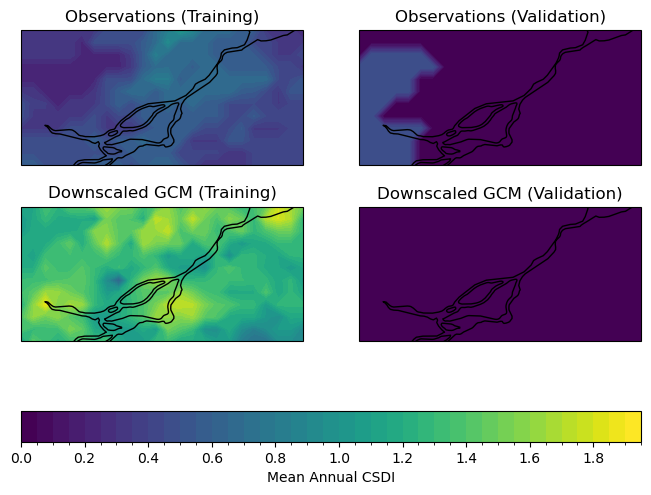

In [24]:
# plot maps of annual CDSI
clevs_csdi = np.arange(0, 2, 0.05)
fig, axes_array = plt.subplots(nrows = 2, ncols = 2, 
                               figsize = (8,6), subplot_kw = spkws)
axes = axes_array.ravel()

CSDI_obs_train.mean('time').plot.contourf(ax = axes[0], levels = clevs_csdi, 
                                          add_colorbar = False)
axes[0].set_title("Observations (Training)")

CSDI_obs_test.mean('time').plot.contourf(ax = axes[1], levels = clevs_csdi, 
                                         add_colorbar = False)
axes[1].set_title("Observations (Validation)")

CSDI_gcm_train.mean('time').plot.contourf(ax = axes[2], levels = clevs_csdi, 
                                          add_colorbar = False)
axes[2].set_title("Downscaled GCM (Training)")

p = CSDI_gcm_test.mean('time').plot.contourf(ax = axes[3], levels = clevs_csdi, 
                                             add_colorbar = False)
axes[3].set_title("Downscaled GCM (Validation)")

fig.colorbar(p, ax = axes.tolist(), 
             extendrect = True,
             orientation = 'horizontal', 
             label = "Mean Annual CSDI")

for ax in axes:
    ax.coastlines()

plt.show()